In [37]:
import os
import numpy as np
import dask.array as da
import metpy.constants as mpconsts
import metpy.units as units
from func import cal_buoyancy  # import the function from your script
from pathlib import Path
import pandas as pd
from func import cal_buoyancy
from sklearn.metrics import mean_squared_error
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import glob
import os
import re
import traceback
from scipy.interpolate import interp1d
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import requests
import datetime
import metpy.calc as mpcalc
from metpy.units import units
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
from scipy.interpolate import interp1d
from scipy.optimize import bisect
import numpy as np
import pickle
import numpy as np
import math
import pint
from pydoc import help
import xarray as xr
import netCDF4 as nc
import re
import matplotlib.pyplot as plt
from numpy import load
from numpy import asarray
from numpy import save
import pytz
from scipy import stats
from sklearn.linear_model import LinearRegression
from collections import Counter
import pymannkendall as mk

In [26]:
backup_dir = os.path.expanduser("~/limited_SGP_domain_arrays")

file_path = os.path.join(backup_dir, "backup_arrays_for_buoyancy.npz")

# Load the .npz file

data = np.load(file_path)

# Check the available arrays inside the file
print("Arrays stored in the file:", data.files)

# Access arrays by their saved names
interp_pres_small = data["interp_pres_small"]

interp_temp_small = data["interp_temp_small"]

interp_q_small = data["interp_q_small"]

interp_qfit_small = data["interp_qfit_small"]

lats_small = data["lats_small"]

lons_small = data["lons_small"]

times = data["times"]

interpolated_altitudes = data["interpolated_altitudes"]

# Print the shape of one of the loaded arrays as a check
print("Shape of interp_pres_small:", interp_pres_small.shape)

mean_q_pbl = np.nanmean(interp_q_small[:, 0:101, :, :], axis=1)  # Shape: (time, lat, lon)

mean_q_lt = np.nanmean(interp_q_small[:, 101:201, :, :], axis=1)  # Shape: (time, lat, lon)

Arrays stored in the file: ['interp_pres_small', 'interp_temp_small', 'interp_q_small', 'interp_qfit_small', 'lats_small', 'lons_small', 'times', 'interpolated_altitudes']
Shape of interp_pres_small: (2754, 201, 10, 10)


In [28]:
lats = np.arange(39, 29.75, -0.25)

lons = np.arange(-105, -94.75, 0.25) 

# Divide into 10 equal sections (10 edges means 11 bin edges)

lat_bins = np.linspace(lats.min(), lats.max(), 11)  

lon_bins = np.linspace(lons.min(), lons.max(), 11)

# Compute the center of each section

lat_centers = (lat_bins[:-1] + lat_bins[1:]) / 2

lon_centers = (lon_bins[:-1] + lon_bins[1:]) / 2

# Find the closest grid indices to these centers

lat_indices = [np.argmin(np.abs(lats - lc)) for lc in lat_centers]

lon_indices = [np.argmin(np.abs(lons - lc)) for lc in lon_centers]

selected_lats = lats[lat_indices]

selected_lons = lons[lon_indices]

selected_grid_points = [(lat, lon) for lat in selected_lats for lon in selected_lons]

times = pd.date_range("2001-05-01", "2018-09-30", freq="D")

times = times[(times.month >= 5) & (times.month <= 9)]  # Filter months 5-9

times = [d.date() for d in times]  # Convert to datetime.date format

In [29]:
with open('ape_df.pkl', 'rb') as f:
    
    fullape_df = pickle.load(f)


ape_df = fullape_df[
    
    (fullape_df['latitude'].isin(selected_lats)) & 
    
    (fullape_df['longitude'].isin(selected_lons)) & 
    
    (fullape_df['date'].isin(times)) & 
    
    (fullape_df['APE'])

].reset_index(drop=True)

nonape_df = fullape_df[
    
    (fullape_df['latitude'].isin(selected_lats)) & 
    
    (fullape_df['longitude'].isin(selected_lons)) & 
    
    (fullape_df['date'].isin(times)) & 
    
    (~fullape_df['APE'])

].reset_index(drop=True)

allcases_df = fullape_df[
    
    (fullape_df['latitude'].isin(selected_lats)) & 
    
    (fullape_df['longitude'].isin(selected_lons)) & 
    
    (fullape_df['date'].isin(times))

].reset_index(drop=True)

print(ape_df.shape, nonape_df.shape, allcases_df.shape)


(79360, 6) (196040, 6) (275400, 6)


In [30]:
num_times = len(times)

lat_grid, lon_grid = np.meshgrid(selected_lats, selected_lons, indexing="ij")

time_expanded = np.repeat(times, 10 * 10)

lat_expanded = np.tile(lat_grid.flatten(), num_times)

lon_expanded = np.tile(lon_grid.flatten(), num_times)

# flatten blc and blt

mean_q_pbl_flat = mean_q_pbl.flatten()

mean_q_lt_flat = mean_q_lt.flatten()

q_df = pd.DataFrame({
    
    "date": time_expanded,
    
    "latitude": lat_expanded,
    
    "longitude": lon_expanded,
    
    "qpbl": mean_q_pbl_flat,
    
    "qlt": mean_q_lt_flat
})

ape_wq = ape_df.merge(q_df, on=["date", "latitude", "longitude"], how="left")

nonape_wq = nonape_df.merge(q_df, on=["date", "latitude", "longitude"], how="left")

allcases_wq = allcases_df.merge(q_df, on=["date", "latitude", "longitude"], how="left")

print(ape_wq.shape, nonape_wq.shape, allcases_wq.shape)

(79360, 8) (196040, 8) (275400, 8)


In [33]:
ape_agg_df = ape_wq.groupby(["latitude", "longitude"], as_index=False)[['qpbl', 'qlt']].mean()

nonape_agg_df = nonape_wq.groupby(["latitude", "longitude"], as_index=False)[['qpbl', 'qlt']].mean()

allcases_agg_df = allcases_wq.groupby(["latitude", "longitude"], as_index=False)[['qpbl', 'qlt']].std()

allcases_agg_df.rename(columns={'qpbl': 'std_qpbl', 'qlt': 'std_qlt'}, inplace=True)

# Merge APE and non-APE DataFrames

merged_df = pd.merge(ape_agg_df, nonape_agg_df, on=['latitude', 'longitude'], suffixes=('_ape', '_nonape'))

# Merge standard deviation DataFrame

merged_df = pd.merge(merged_df, allcases_agg_df, on=['latitude', 'longitude'])

# Standardized anomaly calculation

merged_df['qpbl_stnd_anom'] = (merged_df['qpbl_ape'] - merged_df['qpbl_nonape']) / merged_df['std_qpbl']

merged_df['qlt_stnd_anom'] = (merged_df['qlt_ape'] - merged_df['qlt_nonape']) / merged_df['std_qlt']

# Selecting final columns
result_df = merged_df[['latitude', 'longitude', 'qpbl_stnd_anom', 'qlt_stnd_anom']]

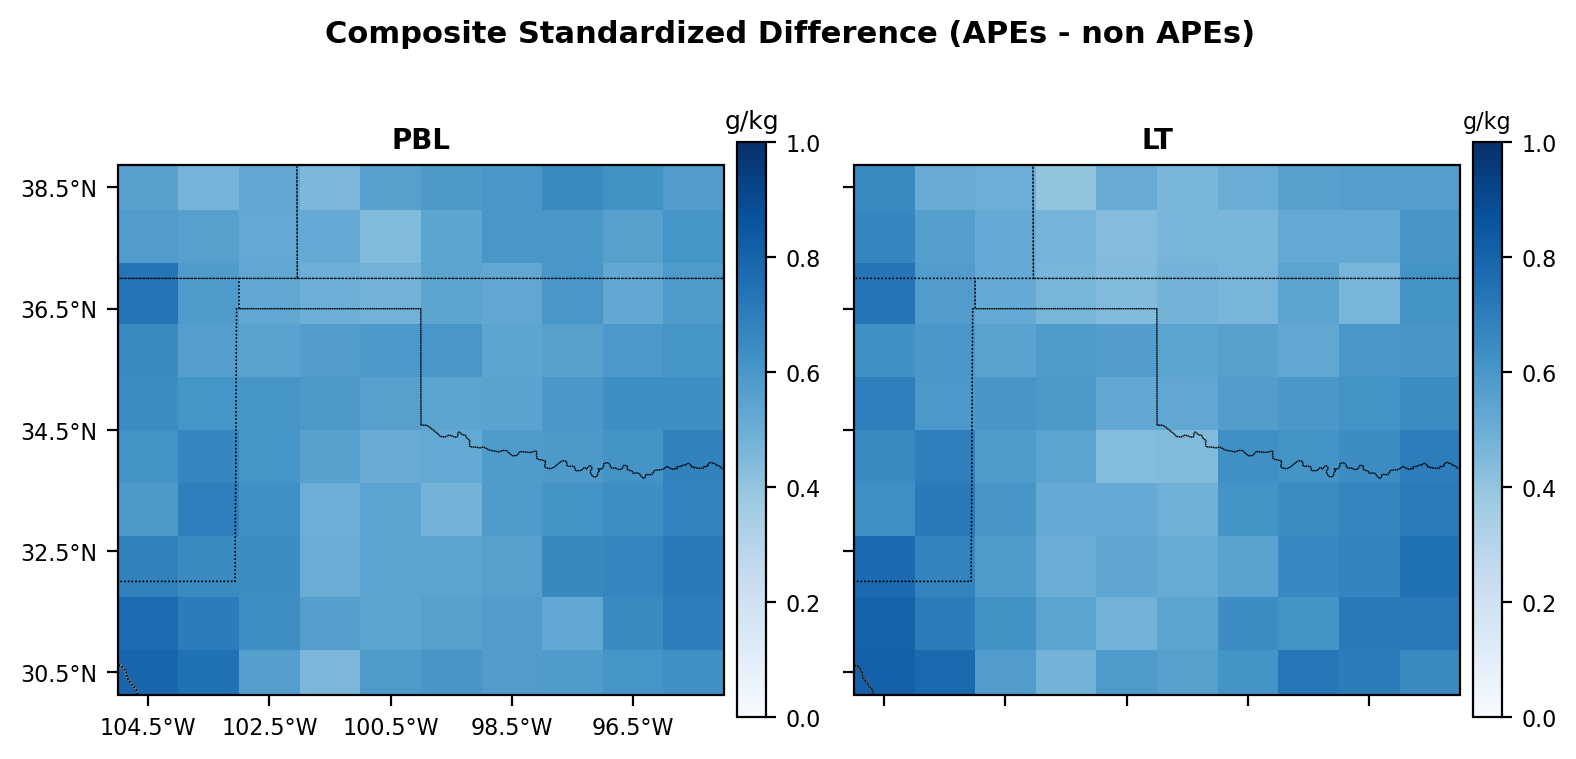

In [41]:
lats = np.sort(result_df["latitude"].unique())

lons = np.sort(result_df["longitude"].unique())

qpbl_grid = result_df.pivot(index="latitude", columns="longitude", values="qpbl_stnd_anom").values

qlt_grid = result_df.pivot(index="latitude", columns="longitude", values="qlt_stnd_anom").values

vmin=0

vmax=1

norm_pbl = plt.Normalize(vmin=vmin, vmax=vmax)

norm_lt = plt.Normalize(vmin=vmin, vmax=vmax)

def plot_heatmap(ax, data, title, norm, cmap, label_ticks=True):
    
    mesh = ax.pcolormesh(lons, lats, data, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, shading="auto")
    
    ax.coastlines(linewidth=0.8)
    
    ax.add_feature(cfeature.BORDERS, linestyle="-", linewidth=0.6, edgecolor="gray")
    
    ax.add_feature(cfeature.STATES, linestyle=":", linewidth=0.5, edgecolor="black")
    
    ax.set_xticks(np.arange(np.min(lons), np.max(lons) + 1, 2), crs=ccrs.PlateCarree()) 
    
    ax.set_yticks(np.arange(np.min(lats), np.max(lats) + 1, 2), crs=ccrs.PlateCarree())

    # Reduce tick size
    ax.tick_params(axis="both", which="major", length=4, width=0.8, labelsize=8)
    
    ax.tick_params(axis="both", which="minor", length=2, width=0.5, labelsize=8)

    # Only label ticks on the left figure
    if label_ticks:
        
        ax.xaxis.set_major_formatter(LongitudeFormatter())
        
        ax.yaxis.set_major_formatter(LatitudeFormatter())
    
    else:
        
        ax.set_xticklabels([])
        
        ax.set_yticklabels([])

    ax.set_title(title, fontsize=10, fontweight="bold", pad=6)

    return mesh  
 

fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=200, subplot_kw={"projection": ccrs.PlateCarree()})

mesh1 = plot_heatmap(axes[0], qpbl_grid, "PBL", norm_pbl, "Blues", label_ticks=True)

mesh2 = plot_heatmap(axes[1], qlt_grid, "LT", norm_lt, "Blues", label_ticks=False)

cbar1 = fig.colorbar(mesh1, ax=axes[0], orientation="vertical", fraction=0.05, pad=0.02, shrink=0.9)

cbar1.ax.tick_params(labelsize=8)

cbar1.ax.xaxis.set_label_position("top")

cbar1.ax.set_xlabel("g/kg", fontsize=9, labelpad=5)

cbar2 = fig.colorbar(mesh2, ax=axes[1], orientation="vertical", fraction=0.05, pad=0.02, shrink=0.9)

cbar2.ax.tick_params(labelsize=8)

cbar2.ax.xaxis.set_label_position("top")

cbar2.ax.set_xlabel("g/kg", fontsize=8, labelpad=5)

fig.suptitle("Composite Standardized Difference (APEs - non APEs)", fontsize=11, fontweight="bold", y=0.95)  

fig.tight_layout(rect=[0, 0, 1, 0.95])  

plt.show()
